In [9]:
import os
import re
import torch
import shap
import matplotlib
import joblib
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.cm as cm
import seaborn as sns
from sklearn.svm import SVR
from IPython.display import display, HTML
import torch.nn.functional as F
import torch.nn.init as init
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
import torch.optim as optim
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from scipy.interpolate import make_interp_spline

In [10]:
Syngas_data=pd.read_csv('./Paper_1') 

In [11]:
Syngas_data

,Sr.,Ref.,C (%),H (%),O (%),N (%),S(%),Ash (%),BTW(ratio),Particle size(mm),Temp. C,P (MPa),Res- Time (min),H2 mol/kg,CO2 mol/kg,CO mol/kg,CH4 mol/kg,Unnamed: 17
0,1,[1],41.98,5.05,47.46,0.46,0.45,4.6,5.0,0.80,300,23.5,45,0.99,3.71,0.06,0.27,Hydrothermal gasification of soybean straw and...
1,2,[1],41.98,5.05,47.46,0.46,0.45,4.6,5.0,0.80,400,23.5,45,2.33,3.43,0.04,0.97,NaN
2,3,[1],41.98,5.05,47.46,0.46,0.45,4.6,5.0,0.80,500,23.5,45,3.37,4.58,0.02,1.71,NaN
3,4,[1],41.98,5.05,47.46,0.46,0.45,4.6,5.0,0.80,500,23.5,45,3.38,4.62,0.03,1.72,NaN
4,5,[1],41.98,5.05,47.46,0.46,0.45,4.6,10.0,0.80,500,23.5,45,3.84,5.28,0.00,3.21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,236,[28],42.60,6.60,58.80,0.00,0.00,0.1,4.0,0.05,500,16.5,30,0.95,2.26,0.00,0.78,NaN
236,237,[28],42.60,6.60,58.80,0.00,0.00,0.1,7.0,0.05,400,16.5,30,0.72,2.19,0.00,0.06,NaN
237,238,[28],42.60,6.60,58.80,0.00,0.00,0.1,7.0,0.05,470,16.5,30,0.80,2.53,0.00,0.33,NaN
238,239,[28],42.60,6.60,58.80,0.00,0.00,0.1,7.0,0.05,500,16.5,30,1.16,2.88,0.00,0.82,NaN


In [12]:
Syngas_data=Syngas_data.iloc[:, 2:-1]

In [13]:
Syngas_data

,C (%),H (%),O (%),N (%),S(%),Ash (%),BTW(ratio),Particle size(mm),Temp. C,P (MPa),Res- Time (min),H2 mol/kg,CO2 mol/kg,CO mol/kg,CH4 mol/kg
0,41.98,5.05,47.46,0.46,0.45,4.6,5.0,0.80,300,23.5,45,0.99,3.71,0.06,0.27
1,41.98,5.05,47.46,0.46,0.45,4.6,5.0,0.80,400,23.5,45,2.33,3.43,0.04,0.97
2,41.98,5.05,47.46,0.46,0.45,4.6,5.0,0.80,500,23.5,45,3.37,4.58,0.02,1.71
3,41.98,5.05,47.46,0.46,0.45,4.6,5.0,0.80,500,23.5,45,3.38,4.62,0.03,1.72
4,41.98,5.05,47.46,0.46,0.45,4.6,10.0,0.80,500,23.5,45,3.84,5.28,0.00,3.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,42.60,6.60,58.80,0.00,0.00,0.1,4.0,0.05,500,16.5,30,0.95,2.26,0.00,0.78
236,42.60,6.60,58.80,0.00,0.00,0.1,7.0,0.05,400,16.5,30,0.72,2.19,0.00,0.06
237,42.60,6.60,58.80,0.00,0.00,0.1,7.0,0.05,470,16.5,30,0.80,2.53,0.00,0.33
238,42.60,6.60,58.80,0.00,0.00,0.1,7.0,0.05,500,16.5,30,1.16,2.88,0.00,0.82


In [14]:
X_columns = ['C (%)', 'H (%)', 'O (%)', 'N (%)','S(%)', 'Ash (%)', 'BTW(ratio)', 'Particle size(mm)','Temp. C', 'P (MPa)', 'Res- Time (min)'] 
Y_columns = ['H2 mol/kg', 'CO2 mol/kg', 'CO mol/kg', 'CH4 mol/kg']

In [15]:
#Y_columns = ['H2 mol/kg']
X = Syngas_data[X_columns]
Y = Syngas_data[Y_columns]

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

features = scaler_X.fit_transform(X)

labels = scaler_Y.fit_transform(Y)

In [16]:
# 转换为 PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.Tensor(features)
        self.labels = torch.Tensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]


In [17]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [18]:
features_test, features_dev, labels_test, labels_dev = train_test_split(features_test, labels_test, test_size=0.15, random_state=30)

In [19]:
features_train.shape

(192, 11)

In [20]:

train_dataset = CustomDataset(features_train, labels_train)
test_dataset = CustomDataset(features_test, labels_test)
dev_dataset = CustomDataset(features_dev, labels_dev)

In [21]:

class ANeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, weight_decay=0.0):
        super(ANeuralNetwork, self).__init__()


        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_sizes)):
            if i == 0:
                layer = nn.Linear(input_size, hidden_sizes[i])
            else:
                layer = nn.Linear(hidden_sizes[i - 1], hidden_sizes[i])
            self.hidden_layers.append(layer)

            self.hidden_layers.append(nn.Tanh())

        self.output_layer = nn.Linear(hidden_sizes[-1] if hidden_sizes else input_size, output_size)


        self.weight_decay = weight_decay

    def forward(self, x):

        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

In [22]:
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,drop_last=False)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False,drop_last=False)

In [23]:

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.hidden_layers = model.hidden_layers

    def forward(self, x):
        features = []
        for layer in self.hidden_layers:
            x = F.tanh(layer(x))
            features.append(x)
        return torch.cat(features, dim=1)  

In [24]:

def set_evaluation_mode(model):
    model.eval()

In [25]:
def extract_features(model, data_loader, device='cpu'):
    features = []
    labels = []
    model.to(device)
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if isinstance(outputs, list):
                for output in outputs:
                    features.append(output.view(output.size(0), -1))
            else:  
                features.append(outputs.view(outputs.size(0), -1))
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)


In [26]:
trained_ANN_model = ANeuralNetwork(input_size=11, hidden_sizes=[16,8], output_size=4, weight_decay=0.005)
trained_ANN_model.load_state_dict(torch.load('C:/Users/18672/Desktop/selfwork/machine learning/paper 3/model_file/own dataset/Model_weight/ANN-SVM_ann.pth', map_location=torch.device('cpu')))
trained_SVR_model = joblib.load('C:/Users/18672/Desktop/selfwork/machine learning/paper 3/model_file/own dataset/Model_weight/ANN-SVM_svm.pkl')


def combined_model_predict(trained_ann,trained_svm,features_train): 
    feature_extractor_own = FeatureExtractor(trained_ann)    
    features_train = torch.Tensor(features_train)
    X_features =  feature_extractor_own(features_train)
    predictions = trained_svm.predict(X_features.detach().numpy())
    return predictions

C:\Users\18672\AppData\Local\Temp\ipykernel_21612\2410131306.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_ANN_model.load_state_dict(torch.load('C:/Users/18672

In [27]:
def combined_model(FEATURE):
    predictions_train_own = []
    predictions_batch = combined_model_predict(trained_ANN_model, trained_SVR_model, FEATURE)
    predictions_train_own.append(predictions_batch)
    return predictions_train_own[0]

## 这个下面就是属于SHAP

In [48]:
explainer = shap.Explainer(combined_model, features_train)
shap_values = explainer.shap_values(features_train)

PermutationExplainer explainer: 193it [02:21,  1.25it/s]                                                               


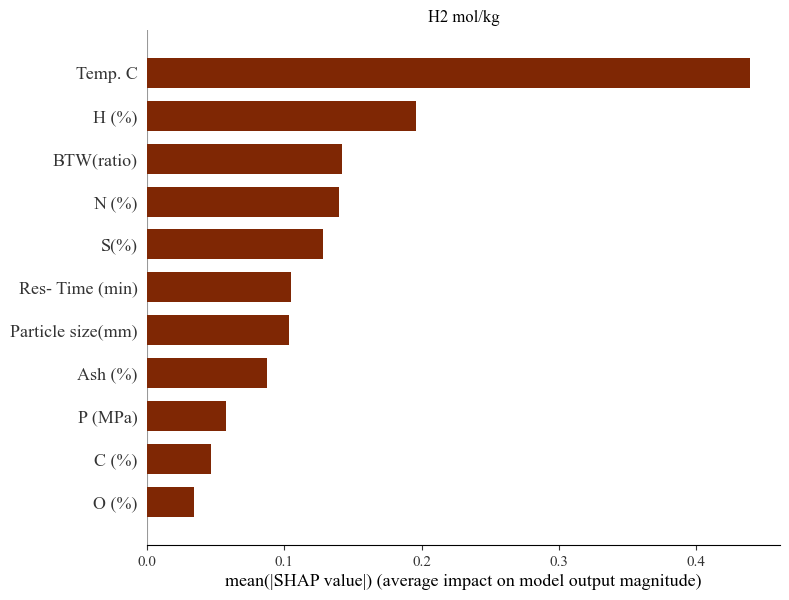

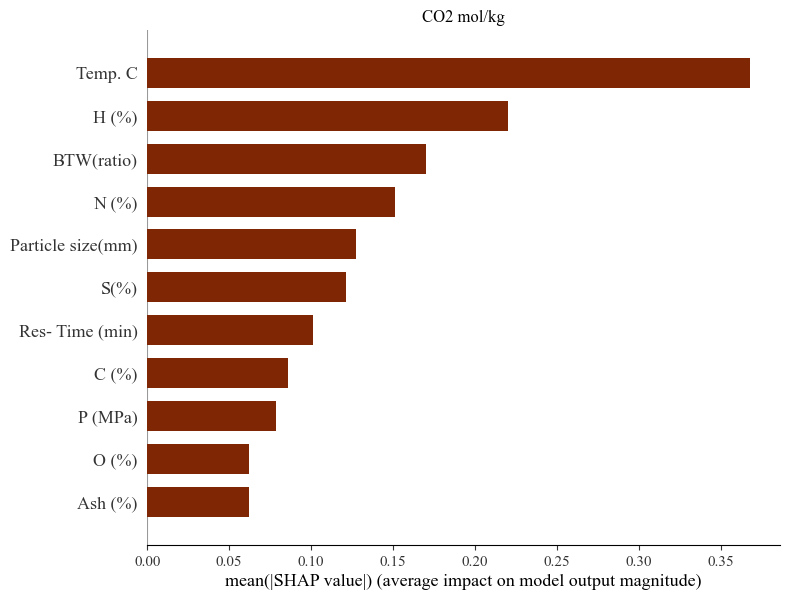

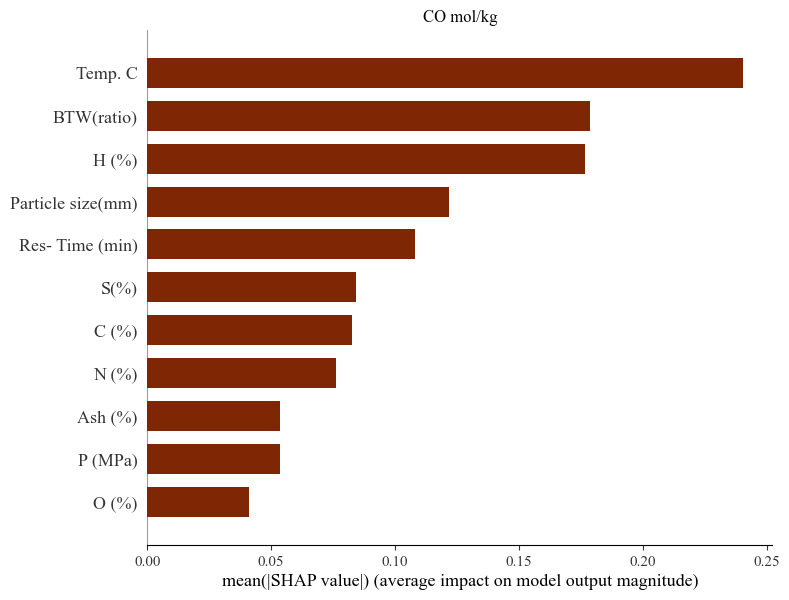

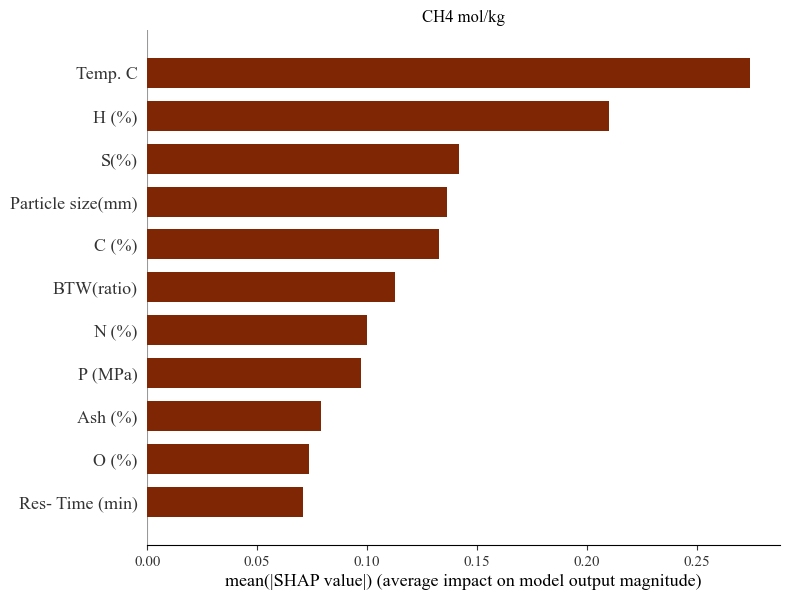

In [59]:
for output_idx in range(4):
    shap_vals_output = [shap_values[:,:,output_idx]]
    
    plt.figure(figsize=(10, 8)) 
    
    shap.summary_plot(shap_vals_output, features_train, feature_names=X_columns, show=False, 
                      color=matplotlib.cm.Oranges.reversed(), color_bar=False)
    
    plt.title(Y_columns[output_idx])  
    plt.gca().get_legend().remove()  
    # plt.savefig(f'{output_idx}.png')
    plt.show() 

H2 mol/kg:
  Biomass Element: 0.4271441863711283
  Gasification Conditions: 0.5728558136288718
CO2 mol/kg:
  Biomass Element: 0.4540858114539298
  Gasification Conditions: 0.5459141885460701
CO mol/kg:
  Biomass Element: 0.4224771020890374
  Gasification Conditions: 0.5775228979109628
CH4 mol/kg:
  Biomass Element: 0.5160300717816446
  Gasification Conditions: 0.48396992821835516


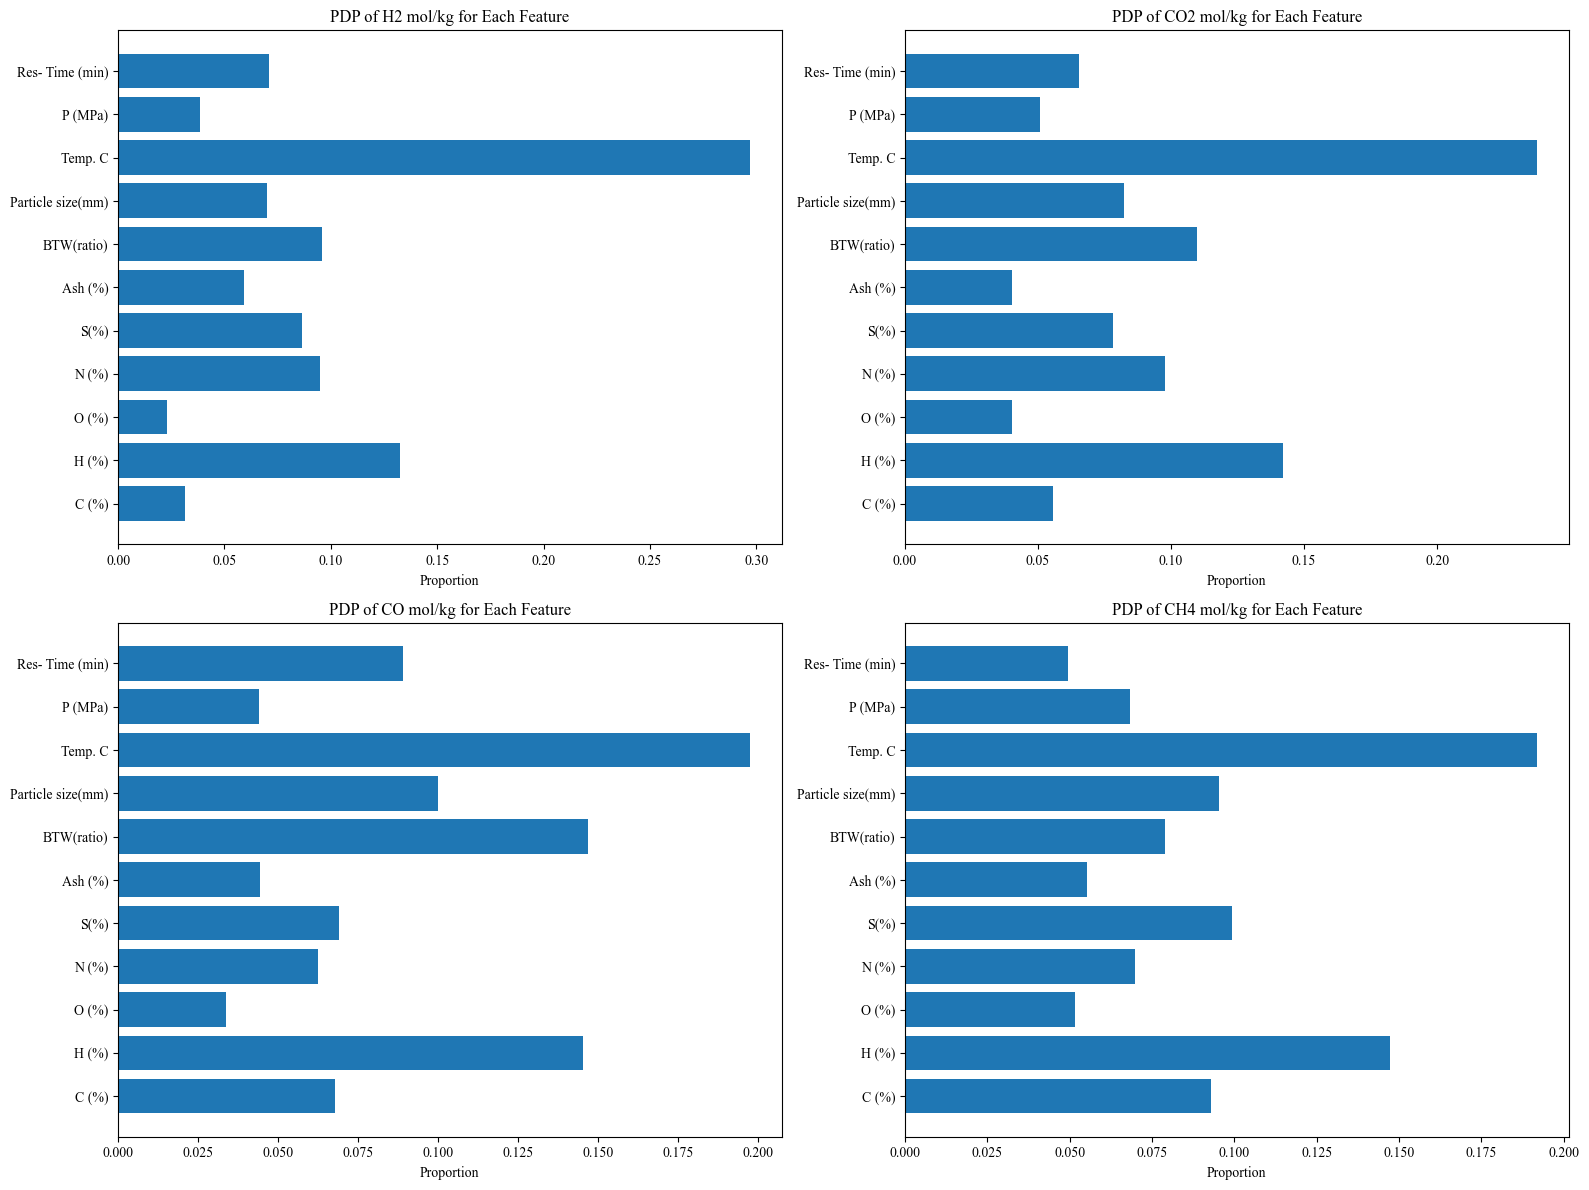

In [60]:

num_outputs = 4


fig, axs = plt.subplots(2, 2, figsize=(16, 12))


for output_idx in range(num_outputs):

    shap_abs_sum_per_feature = np.sum(np.abs(shap_values[:, :, output_idx]), axis=0)
    total_shap_abs_sum = np.sum(shap_abs_sum_per_feature)
    feature_proportions = shap_abs_sum_per_feature / total_shap_abs_sum

    row = output_idx // 2
    col = output_idx % 2
    ax = axs[row, col]
    ax.barh(X_columns, feature_proportions)
    ax.set_title(f'PDP of {Y_columns[output_idx]} for Each Feature')
    ax.set_xlabel('Proportion')

    np.savetxt(f'X_columns_output_{output_idx + 1}.txt', X_columns, fmt='%s', delimiter='\t', header='X Columns')
    np.savetxt(f'feature_proportions_output_{output_idx + 1}.txt', feature_proportions, fmt='%.18e', delimiter='\t', header='Feature Proportions')

    print(f'{Y_columns[output_idx]}:')
    print(f'  Biomass Element: {np.sum(feature_proportions[0:6])}')
    print(f'  Gasification Conditions: {np.sum(feature_proportions[6:])}')


plt.tight_layout()
# plt.savefig('PDP.png')
plt.show()


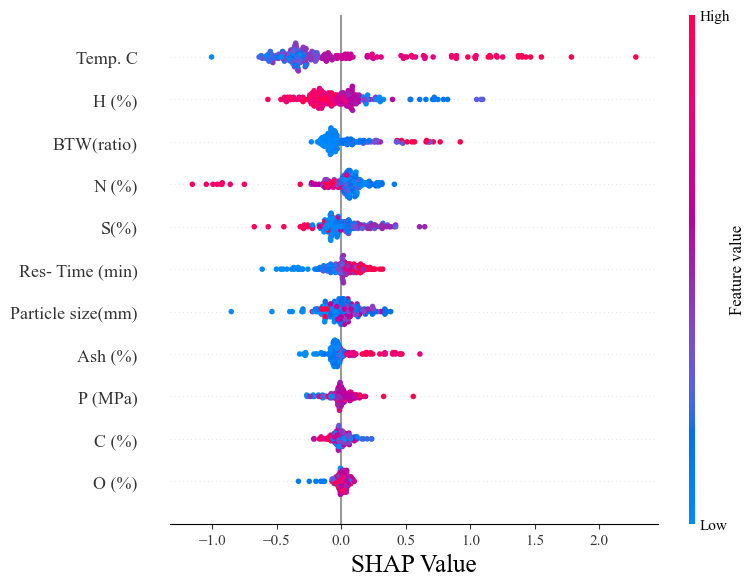

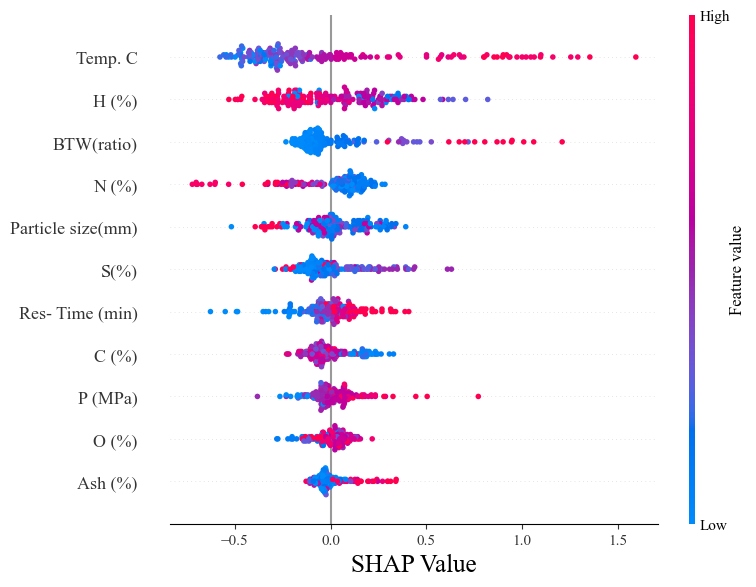

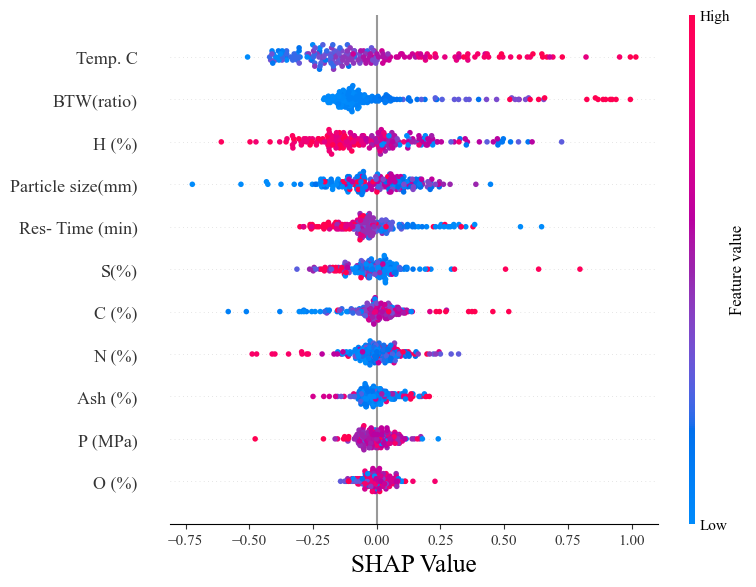

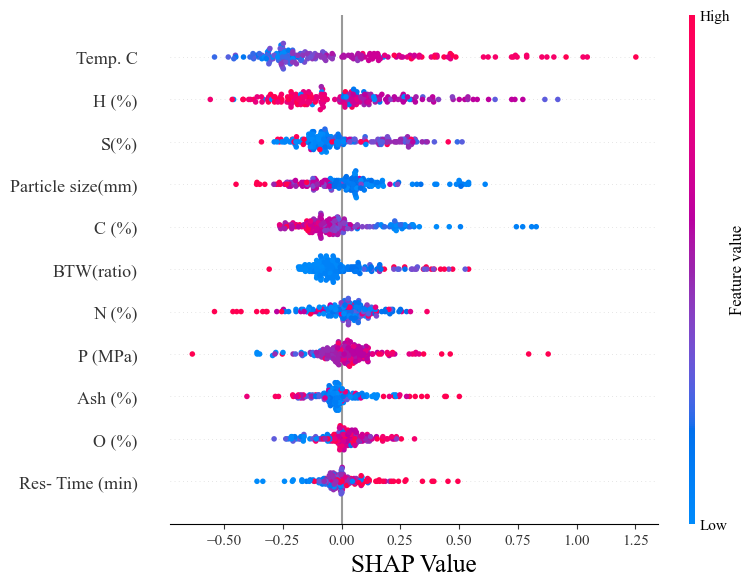

In [62]:

shap_values_3d = np.transpose(shap_values, (2, 0, 1))  # (n_classes, n_samples, n_features)


for i in range(len(Y_columns)):

    shap_df = pd.DataFrame(shap_values_3d[i], columns=X_columns)
    shap_df['Sample Index'] = range(shap_values_3d[i].shape[0])  

    plt.figure(figsize=(20, 15))
    shap.summary_plot(shap_values_3d[i], features_train, plot_type="dot", show=False, feature_names=X_columns)

    # plt.title(Y_columns[i], fontsize=20)
    plt.xlabel("SHAP Value", fontsize=18)
    # plt.ylabel("Feature", fontsize=18)
    # plt.savefig(f'{Y_columns[i]}.png')

    plt.show()

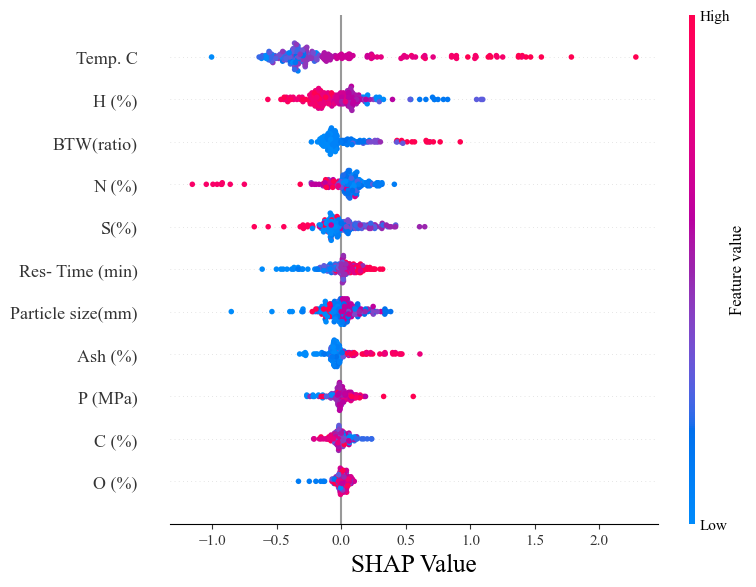

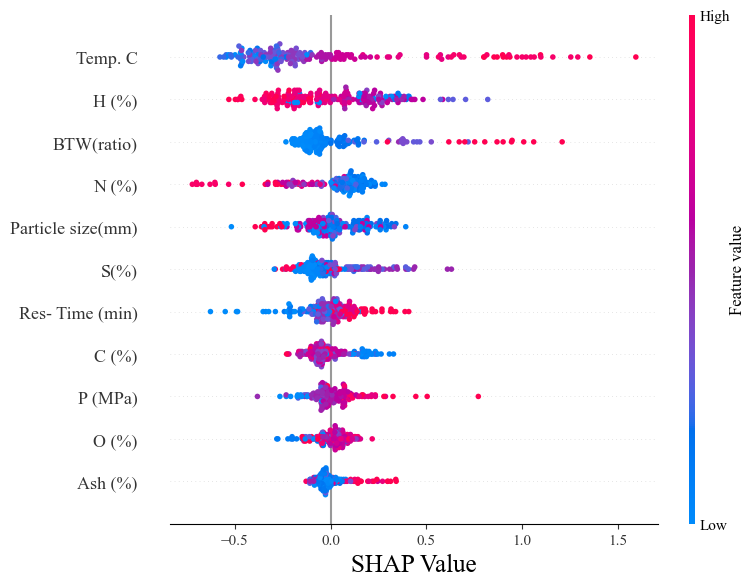

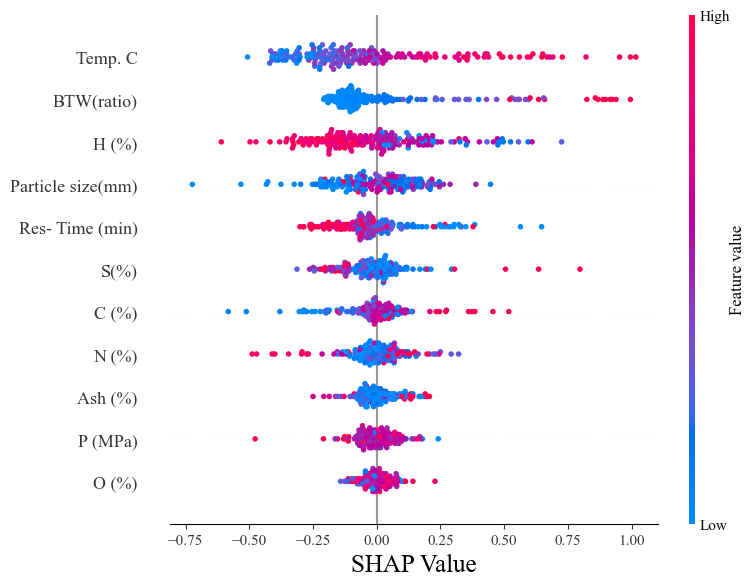

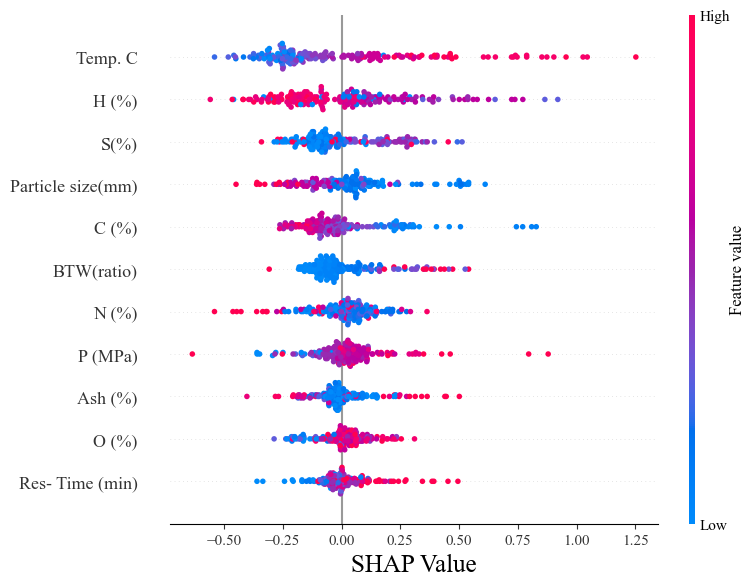

In [63]:
def clean_filename(filename):

    return re.sub(r'[^\w\s-]', '', filename).strip()



shap_values_3d = np.transpose(shap_values, (2, 0, 1))

explainer = shap.Explainer(combined_model, features_train)

plt.rcParams["font.family"] = "Times New Roman"



for i in range(len(Y_columns)):
    plt.figure(figsize=(20, 15)) 
    
    shap.summary_plot(shap_values_3d[i], features_train, plot_type="dot", show=False, feature_names=X_columns)

    # plt.title(Y_columns[i], fontdict={'fontsize': 20})
    plt.xlabel("SHAP Value", fontdict={'fontsize': 18})
    # plt.ylabel("Feature")
    

    cleaned_filename = clean_filename(Y_columns[i])

    plt.show() 


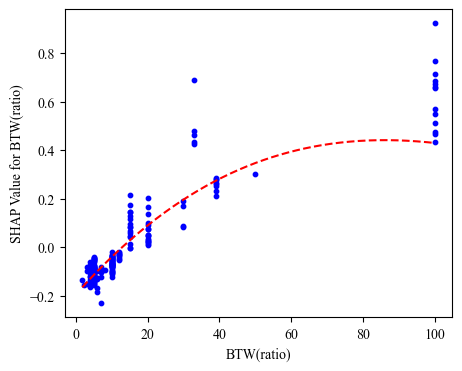

In [64]:
from scipy.interpolate import UnivariateSpline
original_feature_values = scaler_X .inverse_transform(features_train)

def clean_filename(filename):

    return re.sub(r'[^\w\s-]', '', filename).strip()



plt.rcParams["font.family"] = "Times New Roman"

shap_values_3d = np.transpose(shap_values, (2, 0, 1)) 


# selected_features = ["Temp. C", "H (%)", "BTW(ratio)", "N (%)"]
# X_columns = ['C (%)', 'H (%)', 'O (%)', 'N (%)','S(%)', 'Ash (%)', 'BTW(ratio)', 'Particle size(mm)','Temp. C', 'P (MPa)', 'Res- Time (min)'] 
selected_features = ['BTW(ratio)']
selected_indices = [X_columns.index(feature) for feature in selected_features]


# print(f"Selected indices: {selected_indices}")
# print(f"X_columns: {X_columns}")
# print(f"shap_values_3d shape: {shap_values_3d.shape}")

fig, axs = plt.subplots(1, len(selected_features), figsize=(5, 4))
# axs_flat = axs.flatten()

for i, feature_index in enumerate(selected_indices):
    feature_name = X_columns[feature_index]
    

    shap_values_for_feature = shap_values_3d[0][:, feature_index]
    feature_values = original_feature_values[:, feature_index]
    
    axs.scatter(feature_values, shap_values_for_feature, s=10, color='blue')
    unique_feature_values, unique_indices = np.unique(feature_values, return_index=True)
    unique_shap_values_for_feature = shap_values_for_feature[unique_indices]
    
    if len(unique_feature_values) > 1:
        sort_idx = np.argsort(unique_feature_values)
        spl = UnivariateSpline(unique_feature_values[sort_idx], unique_shap_values_for_feature[sort_idx], s=0.5, k=3)
        x_smooth = np.linspace(unique_feature_values.min(), unique_feature_values.max(), 300)
        y_smooth = spl(x_smooth)
        axs.plot(x_smooth, y_smooth, 'r--')
    

    # axs[i].set_title(feature_name)
    axs.set_xlabel(feature_name)
    axs.set_ylabel(f'SHAP Value for {feature_name}')

    cleaned_filename = clean_filename(X_columns[i])


    # plt.savefig('others.png')




plt.show()

   Temp. C_bins  SHAP_values
0             0    -0.091291
1             1     0.055719
2             2     0.133523
3             3     0.349776
4             4     0.303000
5             9     0.621048


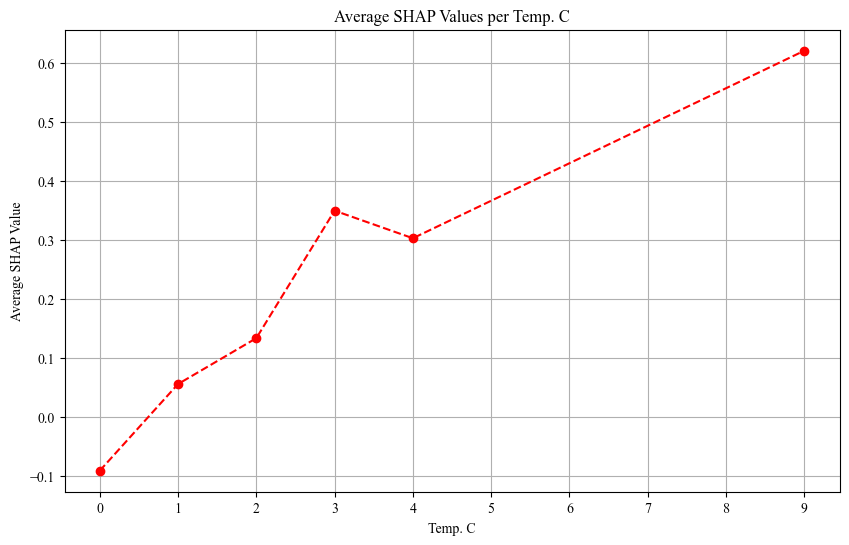

In [65]:
# X_columns = ['C (%)', 'H (%)', 'O (%)', 'N (%)','S(%)', 'Ash (%)', 'BTW(ratio)', 'Particle size(mm)','Temp. C', 'P (MPa)', 'Res- Time (min)'] 
original_feature_values = scaler_X .inverse_transform(features_train)
feature_index = 6 
data = {
    'Temp. C':original_feature_values[:, feature_index],
    'SHAP_values': shap_values_3d[0][:, feature_index]  
}

num_bins = 10
df = pd.DataFrame(data)

df['Temp. C_bins'] = pd.cut(df['Temp. C'], bins=num_bins, labels=False)


average_shap = df.groupby('Temp. C_bins')['SHAP_values'].mean().reset_index()


print(average_shap)
original_feature_values[:, feature_index]
min_number = np.min(original_feature_values[:, feature_index])
max_number = np.max(original_feature_values[:, feature_index])
number_points = 5
X_number = np.linspace(min_number, max_number, number_points )



plt.figure(figsize=(10, 6))
plt.plot(average_shap['Temp. C_bins'], average_shap['SHAP_values'], marker='o', linestyle='--', color='r')
plt.title('Average SHAP Values per Temp. C')
plt.xlabel('Temp. C')
plt.ylabel('Average SHAP Value')
plt.grid()
plt.xticks(range(num_bins))
plt.show()

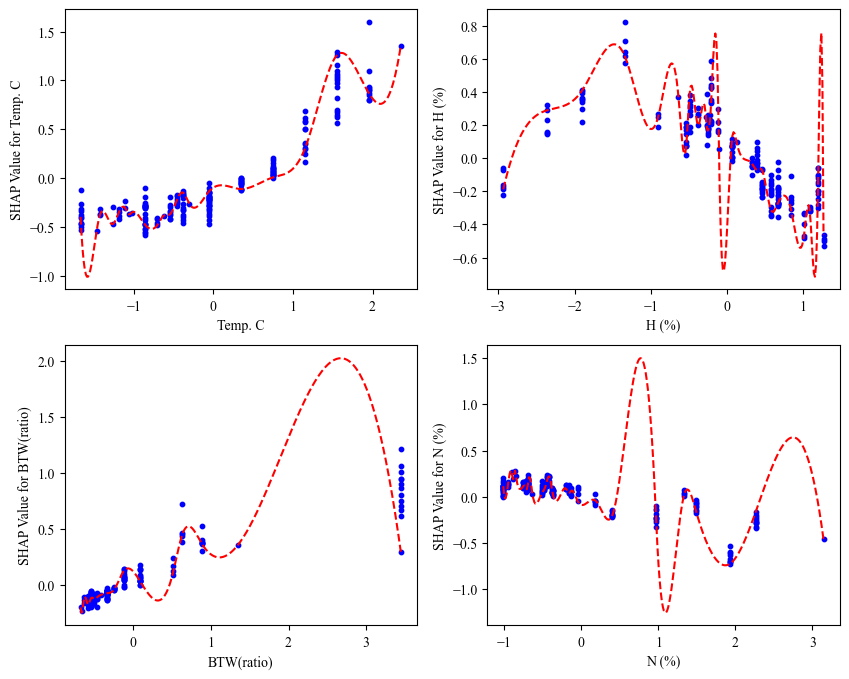

In [66]:
def clean_filename(filename):

    return re.sub(r'[^\w\s-]', '', filename).strip()



plt.rcParams["font.family"] = "Times New Roman"

shap_values_3d = np.transpose(shap_values, (2, 0, 1)) 


selected_features = ["Temp. C", "H (%)", "BTW(ratio)", "N (%)"]
# X_columns = ['C (%)', 'H (%)', 'O (%)', 'N (%)','S(%)', 'Ash (%)', 'BTW(ratio)', 'Particle size(mm)','Temp. C', 'P (MPa)', 'Res- Time (min)'] 
# selected_features = ['C (%)', 'O (%)', 'S(%)', 'Ash (%)','Particle size(mm)','P (MPa)', 'Res- Time (min)']
selected_indices = [X_columns.index(feature) for feature in selected_features]



fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs_flat = axs.flatten()

for i, feature_index in enumerate(selected_indices):
    feature_name = X_columns[feature_index]

    shap_values_for_feature = shap_values_3d[1][:, feature_index]
    feature_values = features_train[:, feature_index]
    

    axs_flat[i].scatter(feature_values, shap_values_for_feature, s=10, color='blue')
    

    unique_feature_values, unique_indices = np.unique(feature_values, return_index=True)
    unique_shap_values_for_feature = shap_values_for_feature[unique_indices]

    if len(unique_feature_values) > 1:
        sort_idx = np.argsort(unique_feature_values)
        x_smooth = np.linspace(unique_feature_values.min(), unique_feature_values.max(), 300)
        y_smooth = make_interp_spline(unique_feature_values[sort_idx], unique_shap_values_for_feature[sort_idx])(x_smooth)
        axs_flat[i].plot(x_smooth, y_smooth, 'r--')
    

    # axs_flat[i].set_title(feature_name)
    axs_flat[i].set_xlabel(feature_name)
    axs_flat[i].set_ylabel(f'SHAP Value for {feature_name}')

    cleaned_filename = clean_filename(X_columns[i])


plt.show()

# PDP

In [69]:

# X_columns = ['C (%)', 'H (%)', 'O (%)', 'N (%)','S(%)', 'Ash (%)', 'BTW(ratio)', 'Particle size(mm)','Temp. C', 'P (MPa)', 'Res- Time (min)'] 
input_feature_index_1 = 8  
input_feature_index_2 = 7 


output_index = 3 


shap_values_input_output = shap_values[:, [input_feature_index_1, input_feature_index_2], output_index]


min_value_1 = np.min(features_train[:, input_feature_index_1])
max_value_1 = np.max(features_train[:, input_feature_index_1])
min_value_2 = np.min(features_train[:, input_feature_index_2])
max_value_2 = np.max(features_train[:, input_feature_index_2])
num_points = shap_values.shape[0] 

feature_values_1 = np.linspace(min_value_1, max_value_1, num_points)
feature_values_2 = np.linspace(min_value_2, max_value_2, num_points)


partial_dependence_values = np.zeros((len(feature_values_1), len(feature_values_2)))
for i, value_1 in enumerate(feature_values_1):
    for j, value_2 in enumerate(feature_values_2):
        input_feature = features_train.copy()
        input_feature[:, input_feature_index_1] = value_1
        input_feature[:, input_feature_index_2] = value_2
        prediction = combined_model(input_feature)
        partial_dependence_values[i, j] = prediction[0, output_index]


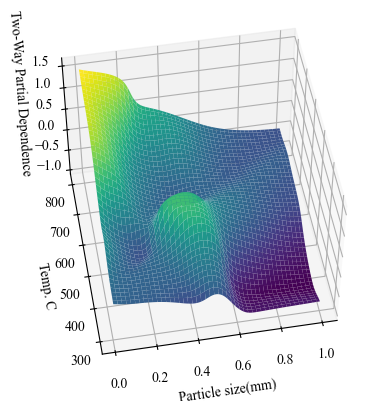

In [70]:
min_syn_1 = np.min(Syngas_data.iloc[:, input_feature_index_1])
max_syn_1 = np.max(Syngas_data.iloc[:, input_feature_index_1])
min_syn_2 = np.min(Syngas_data.iloc[:, input_feature_index_2])
max_syn_2 = np.max(Syngas_data.iloc[:, input_feature_index_2])
num_points = shap_values.shape[0]  


feature_values_1_syn = np.linspace(min_syn_1, max_syn_1 , num_points)
feature_values_2_syn = np.linspace(min_syn_2, max_syn_2, num_points)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(feature_values_2_syn, feature_values_1_syn)
surf = ax.plot_surface(X, Y, partial_dependence_values, cmap='viridis')

ax.set_xlabel(f'{X_columns[input_feature_index_2]}')
ax.set_ylabel(f'{X_columns[input_feature_index_1]}')
ax.set_zlabel('Two-Way Partial Dependence')
ax.view_init(elev=50, azim=260)


plt.show()


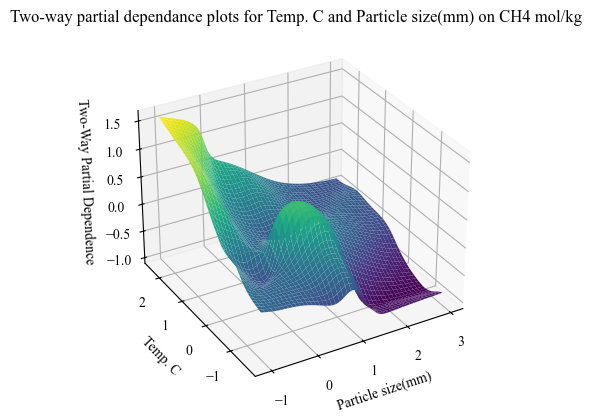

In [71]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


X, Y = np.meshgrid(feature_values_2, feature_values_1)
surf = ax.plot_surface(X, Y, partial_dependence_values, cmap='viridis')


ax.set_xlabel(f'{X_columns[input_feature_index_2]}')
ax.set_ylabel(f'{X_columns[input_feature_index_1]}')
ax.set_zlabel('Two-Way Partial Dependence')

ax.view_init(elev=30, azim=240)

plt.title(f'Two-way partial dependance plots for {X_columns[input_feature_index_1]} and {X_columns[input_feature_index_2]} on {Y_columns[output_index]}')
plt.show()

In [72]:

feature_values_1_original = scaler_X.inverse_transform(np.tile(feature_values_1[:,np.newaxis],(1, 11)))
feature_values_1_ori = feature_values_1_original[:, input_feature_index_1]  


feature_values_2_original = scaler_X.inverse_transform(np.tile(feature_values_2[:,np.newaxis],(1, 11)))
feature_values_2_ori = feature_values_2_original[:, input_feature_index_2]

# data_to_save = np.column_stack((feature_values_1_ori.repeat(len(feature_values_2_ori)), 
#                                 np.tile(feature_values_2_ori, len(feature_values_1_ori)), 
#                                 partial_dependence_values.flatten()))


